# 필요한 라이브러리 Import

In [1]:
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords
kiwi=Kiwi()
stopwords =Stopwords()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import tensorflow as tf

2024-10-07 07:52:44.953079: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 07:52:44.983734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 07:52:44.983768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 07:52:44.984513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 07:52:44.991592: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
import tensorflow as tf
tf.keras.backend.clear_session()

# Part | 데이터 concat 

In [6]:
## 파일 로드
path1 = '/home/chio4696/DLthon_3team/DATA/train/non_casual/back_translated_non_casual.csv'
path2= '/home/chio4696/DLthon_3team/DATA/train/casual/sns_casual.csv'
path3= '/home/chio4696/DLthon_3team/DATA/train/non_casual/gpt_augmented_non_casual.csv'
path4 = '/home/chio4696/DLthon_3team/DATA/train/non_casual/plain_non_casual.csv'
path5 = '/home/chio4696/DLthon_3team/DATA/train/non_casual/spell_checked_non_casual.csv'
data1 = pd.read_csv(path1)
data2 = pd.read_csv(path2)
data3 = pd.read_csv(path3)
data4 = pd.read_csv(path4)
data5 = pd.read_csv(path5)
data2 = data2.sample(n=14612, random_state=42)
data = pd.concat([data2, data1, data3, data4, data5])
data.duplicated(subset=['conversation']).sum()

537

In [7]:
data.drop_duplicates(inplace = True,subset=['conversation'])
data = data.drop(labels=['idx'],axis=1)
data['class'].value_counts()

class
일반 대화          14602
기타 괴롭힘 대화       8107
갈취 대화           7592
직장 내 괴롭힘 대화     6660
협박 대화           6337
Name: count, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43298 entries, 47413 to 3949
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   class         43298 non-null  object
 1   conversation  43298 non-null  object
dtypes: object(2)
memory usage: 1014.8+ KB


# Part | 전처리 Class 

In [9]:
class TextProcessor:
    def __init__(self):
        self.kiwi = Kiwi()
        self.stopwords = Stopwords()
        
    # 데이터 정제 (불필요한 문자, 특수 문자, 이메일, URL, 자음/모음 등 제거)
    def clean_text(self, text):
        # E-mail 제거
        text = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', text)
        # URL 제거
        text = re.sub(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
        # 한글 자음, 모음 제거
        text = re.sub(r'([ㄱ-ㅎㅏ-ㅣ]+)', '', text)
        # 알파벳, 숫자 제거
        text = re.sub(r'([a-zA-Z0-9]+)', '', text)
        # HTML 태그 제거
        text = re.sub(r'<[^>]*>', '', text)
        # 한글과 공백을 제외한 모든 문자 제거
        text = re.sub(r"([?.!,~])", r" \1 ", text)
        text = re.sub(r'[^가-힣0-9?.!,~\s]', '', text)
        # 다중 공백을 단일 공백으로
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # 형태소 분석 및 불용어 제거
    def analyze_morphs(self, text):
        # 형태소 분석 수행 및 불용어 제거
        tokens = [(token.form,token.tag )for token in self.kiwi.tokenize(text, stopwords=self.stopwords)]
        return tokens
    
    # 'EF' 태그가 있는 형태소 제거
    def filter_ef_tag(self, tokens):
        # 'EF' 품사 태그가 있는 형태소 제거
        filtered_tokens = [token[0] for token in tokens if token[1] != 'EF']
        return filtered_tokens

    # 전체 과정 통합 (형태소 분석, EF 품사 및 불용어 제거)
    def process(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.analyze_morphs(cleaned_text)
        tokens_without_ef = self.filter_ef_tag(tokens)
        return tokens_without_ef

In [10]:
processor = TextProcessor()

data['ppc'] = data['conversation'].apply(lambda text: processor.process(text))

In [11]:
data[['conversation','ppc']].head(50)

,conversation,ppc
47413,우리 신랑도 난독증 있나봐 아 짜증나\n 쓱 룰렛 깔고 내가 준걸로 드가라고 했는데...,"[신랑, 난독증, 있, 나, 보, 아, 짜증, 나, 쓱, 룰렛, 깔, 주, 거, ᆯ..."
14938,오빠\n 응응 왜?\n 아버님댁에 혹시 홍삼들어오면\n 응응 내가 다 가져올게\n ...,"[오빠, 응응, 왜, 아버님, 댁, 혹시, 홍삼, 들어오, 응응, 다, 가져오, 먹..."
58060,장기 게임 해봤어?\n 응 해봄 키키\n 넷마블에 있음\n 나는 딱히 보드 게임에 ...,"[장기, 게임, 보, 응, 보, 키키, 넷마블, 있, 딱히, 보드, 게임, 취미, ..."
71404,조카들 크는 거 보니까 육아 할 수 있겠나 싶음 키키\n 진짜 눈 깜빡하면 커져 있...,"[조카, 크, 거, 니까, 육아, 있, 나, 싶, 키키, 진짜, 눈, 깜빡, 커지,..."
15875,그래도 착한 남편들이야 애기도 잘재우고\n 응응 맞어 이만한정도면 훌륭해\n 응 가...,"[그래도, 착하, 남편, 이야, 애기, 잘, 재우, 응응, 맞, 만하, 정도, 훌륭..."
27511,오늘 비 온다고 했었는데 맑네?\n 주말에 비 온다고 하더라.\n 오늘 저녁에 약속...,"[오늘, 비, 오, ᆫ다고, 었었, 는데, 맑, 주말, 비, 오, ᆫ다고, 더라, ..."
65324,오징어 게임 그 번호 유출 봤제\n 응응 봤어 봤어\n 뭔 입장을 발표했던디\n 아...,"[오징어, 게임, 번호, 유출, 응응, 뭐, 입장, 발표, 던디, 아니, 근데, 계..."
75871,난 오늘 저녁 수육 먹었어!\n 수육 좋지 오랜만에 수육 먹고 싶다~\n 응 오빠는...,"[오늘, 저녁, 수육, 먹, 수육, 좋, 오랜만, 수육, 먹, 싶, 응, 오빠, 저..."
22225,땅따먹기 오락실 게임 해봤어?\n 하하 맞아 그거 해봤지!\n 오 하하 그거 은근 ...,"[땅, 따먹, 오락실, 게임, 보, 하하, 맞, 그거, 보, 오, 하하, 그거, 은..."
6148,이사 가면 쇼파 놓을 꺼에요?\n 고민이야 거실이 좁아서\n 지금 집도 처음에 이사...,"[이사, 가, 쇼파, 놓, 꺼, 고민, 거실, 좁, 지금, 집, 처음, 이사, 오,..."


# Part | 빈도수 시각화

In [12]:
df = data.copy()

# 레이블 인코딩
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화' : 4
}
df['class'] = df['class'].map(label_mapping)

In [13]:
# 토크나이저 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['ppc'])

# 시퀀스 인코딩
sequences = tokenizer.texts_to_sequences(df['ppc'])

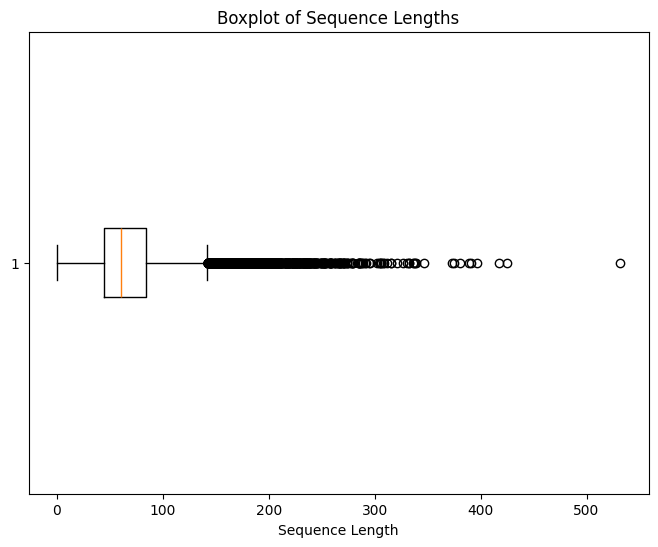

In [14]:
sequence_lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [15]:
# 최대 시퀀스 길이 결정 (% 로 결정)
max_seq_len = 100

In [16]:
# 패딩 적용
X = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

# 레이블 준비
y = df['class'].values

In [17]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 검증 데이터를 8:2로 나눔 (클래스 비율을 유지)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# 결과 확인
print(f"학습 데이터 크기: {X_train.shape}")
print(f"검증 데이터 크기: {X_val.shape}")

학습 데이터 크기: (34638, 100)
검증 데이터 크기: (8660, 100)


In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [19]:
# 패딩 마스크 생성 함수
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # (batch_size, 1, 1, seq_len)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [20]:
def scaled_dot_product_attention(q, k, v, mask):
    """ 스케일드 닷 프로덕트 어텐션 """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Q와 K의 행렬 곱

    # 스케일링
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스크가 주어졌을 경우 -inf 적용
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax를 통해 attention weights 계산
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # attention weights와 V의 행렬곱
    output = tf.matmul(attention_weights, v)

    return output

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 가중치 행렬 정의
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """ 헤드 분할: [batch_size, seq_len, d_model] -> [batch_size, num_heads, seq_len, depth] """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]

        # 선형 변환
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # 헤드 분할
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention = scaled_dot_product_attention(q, k, v, mask)

        # 헤드 병합
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 선형 변환
        output = self.dense(concat_attention)

        return output

    def get_config(self):
        # 직렬화 지원을 위한 설정 저장
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 각도 계산
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 포지셔널 인코딩 계산
        angle_rads = self.get_angles(
            np.arange(position)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # 배열의 홀수 인덱스에는 cos 함수 적용
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [22]:
# 인코더 레이어
def encoder_layer(units, d_model, num_heads, dropout_rate, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 멀티 헤드 어텐션
    attention = MultiHeadAttention(d_model, num_heads)(inputs, inputs, inputs, padding_mask)
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 네트워크
    outputs = tf.keras.layers.Dense(units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [23]:
# 인코더 전체
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout_rate,
            maximum_position_encoding,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 및 포지셔널 인코딩
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(maximum_position_encoding, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    # 인코더 레이어 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout_rate=dropout_rate,
                                name=f"encoder_layer_{i}",
                                )(inputs=[outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [59]:
def residual_block(x, units, dropout_rate=0.4):
    shortcut = x
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tf.keras.layers.Dense(units)(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('tanh')(x)
    return x

# 인코더 모델 생성
def build_encoder_model():
    inputs = tf.keras.Input(shape=(max_seq_len,), name="inputs")
    padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='padding_mask')(inputs)

    # 인코더 출력
    encoder_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout_rate=dropout_rate,
        maximum_position_encoding=max_seq_len,
        name="encoder"
    )(inputs=[inputs, padding_mask])

    # 글로벌 평균 풀링
    pooled_output = tf.keras.layers.GlobalAveragePooling1D()(encoder_outputs)

    residual_output = residual_block(pooled_output, units)

    # 출력 레이어 (다중 분류)
    outputs = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='outputs')(residual_output)

    # 모델 정의
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_classifier")

    return model

In [60]:
# 하이퍼파라미터 설정
vocab_size = len(tokenizer.word_index) + 1
num_layers = 2
d_model = 256
num_heads = 4
units = 512
dropout_rate = 0.4
num_classes = 5  # 클래스 수

In [61]:
# 모델 생성
model = build_encoder_model()

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "transformer_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 100)]                0         []                            
                                                                                                  
 padding_mask (Lambda)       (None, 1, 1, 100)            0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 256)            1044812   ['inputs[0][0]',              
                                                          8          'padding_mask[0][0]']        
                                                                                                  
 global_average_pooling1d_6  (None, 256)                  0         ['encoder

In [62]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='best_model', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# 추가적인 학습률 스케줄러 (선택 사항)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.9651 - accuracy: 0.6054
Epoch 1: val_loss improved from inf to 0.54665, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 98s 43ms/step - loss: 0.9650 - accuracy: 0.6054 - val_loss: 0.5466 - val_accuracy: 0.8159 - lr: 2.0000e-05
Epoch 2/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.4618 - accuracy: 0.8290
Epoch 2: val_loss improved from 0.54665 to 0.35694, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 79s 37ms/step - loss: 0.4617 - accuracy: 0.8291 - val_loss: 0.3569 - val_accuracy: 0.8796 - lr: 2.0000e-05
Epoch 3/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8757
Epoch 3: val_loss improved from 0.35694 to 0.26436, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 73s 34ms/step - loss: 0.3410 - accuracy: 0.8757 - val_loss: 0.2644 - val_accuracy: 0.9148 - lr: 2.0000e-05
Epoch 4/30
2165/2165 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9011
Epoch 4: val_loss improved from 0.26436 to 0.26299, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 74s 34ms/step - loss: 0.2762 - accuracy: 0.9011 - val_loss: 0.2630 - val_accuracy: 0.9164 - lr: 2.0000e-05
Epoch 5/30
2165/2165 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9193
Epoch 5: val_loss improved from 0.26299 to 0.22693, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 84s 39ms/step - loss: 0.2262 - accuracy: 0.9193 - val_loss: 0.2269 - val_accuracy: 0.9318 - lr: 2.0000e-05
Epoch 6/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9313
Epoch 6: val_loss did not improve from 0.22693
2165/2165 [==============================] - 76s 35ms/step - loss: 0.1933 - accuracy: 0.9313 - val_loss: 0.2316 - val_accuracy: 0.9268 - lr: 2.0000e-05
Epoch 7/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9436
Epoch 7: val_loss improved from 0.22693 to 0.15912, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 80s 37ms/step - loss: 0.1601 - accuracy: 0.9436 - val_loss: 0.1591 - val_accuracy: 0.9505 - lr: 2.0000e-05
Epoch 8/30
2165/2165 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9490
Epoch 8: val_loss did not improve from 0.15912
2165/2165 [==============================] - 73s 34ms/step - loss: 0.1412 - accuracy: 0.9490 - val_loss: 0.1642 - val_accuracy: 0.9468 - lr: 2.0000e-05
Epoch 9/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.1226 - accuracy: 0.9577
Epoch 9: val_loss improved from 0.15912 to 0.13285, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 80s 37ms/step - loss: 0.1227 - accuracy: 0.9577 - val_loss: 0.1329 - val_accuracy: 0.9592 - lr: 2.0000e-05
Epoch 10/30
2165/2165 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9626
Epoch 10: val_loss did not improve from 0.13285
2165/2165 [==============================] - 74s 34ms/step - loss: 0.1068 - accuracy: 0.9626 - val_loss: 0.1330 - val_accuracy: 0.9580 - lr: 2.0000e-05
Epoch 11/30
2165/2165 [==============================] - ETA: 0s - loss: 0.0929 - accuracy: 0.9664
Epoch 11: val_loss did not improve from 0.13285

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2165/2165 [==============================] - 74s 34ms/step - loss: 0.0929 - accuracy: 0.9664 - val_loss: 0.1550 - val_accuracy: 0.9555 - lr: 2.0000e-05
Epoch 12/30
2165/2165 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9720
Epoch 12: val_loss improved from 0.13285 to 0.12237, saving model to best

INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 76s 35ms/step - loss: 0.0791 - accuracy: 0.9720 - val_loss: 0.1224 - val_accuracy: 0.9640 - lr: 4.0000e-06
Epoch 13/30
2165/2165 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9754
Epoch 13: val_loss did not improve from 0.12237
2165/2165 [==============================] - 76s 35ms/step - loss: 0.0728 - accuracy: 0.9754 - val_loss: 0.1230 - val_accuracy: 0.9649 - lr: 4.0000e-06
Epoch 14/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9744
Epoch 14: val_loss improved from 0.12237 to 0.11928, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


2165/2165 [==============================] - 81s 38ms/step - loss: 0.0715 - accuracy: 0.9744 - val_loss: 0.1193 - val_accuracy: 0.9657 - lr: 4.0000e-06
Epoch 15/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9761
Epoch 15: val_loss did not improve from 0.11928
2165/2165 [==============================] - 74s 34ms/step - loss: 0.0675 - accuracy: 0.9761 - val_loss: 0.1200 - val_accuracy: 0.9652 - lr: 4.0000e-06
Epoch 16/30
2164/2165 [============================>.] - ETA: 0s - loss: 0.0680 - accuracy: 0.9768
Epoch 16: val_loss did not improve from 0.11928

Epoch 16: ReduceLROnPlateau reducing learning rate to 1e-06.
2165/2165 [==============================] - 78s 36ms/step - loss: 0.0680 - accuracy: 0.9767 - val_loss: 0.1232 - val_accuracy: 0.9639 - lr: 4.0000e-06
Epoch 17/30
 676/2165 [========>.....................] - ETA: 45s - loss: 0.0685 - accuracy: 0.9761

KeyboardInterrupt: 

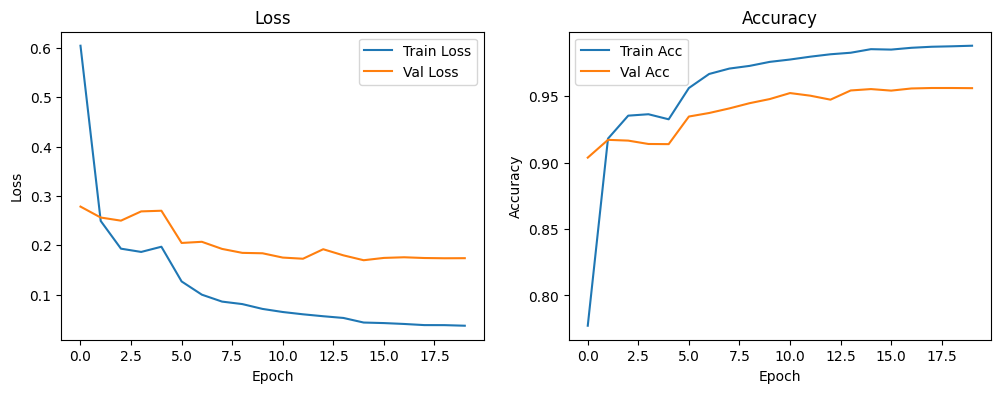

In [63]:
import matplotlib.pyplot as plt

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [64]:
from sklearn.metrics import classification_report
from keras.models import load_model

# PositionalEncoding 클래스를 포함한 custom_objects 정의
custom_objects = {
    'MultiHeadAttention': MultiHeadAttention,
    'PositionalEncoding': PositionalEncoding
}

# SavedModel 형식으로 저장된 모델 불러오기
best_model = load_model('best_model', custom_objects=custom_objects)

# 검증 데이터에 대한 예측
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 분류 보고서를 딕셔너리 형태로 얻기
report_dict = classification_report(y_val, y_pred_classes, target_names=label_mapping.keys(), output_dict=True)

# 딕셔너리를 DataFrame으로 변환
report_df = pd.DataFrame(report_dict).transpose()

# 필요한 컬럼만 선택하고 순서 지정
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]

# 소수점 자릿수 설정
report_df = report_df.round(4)

# 결과 확인
report_df

271/271 [==============================] - 4s 13ms/step


,precision,recall,f1-score,support
협박 대화,0.9337,0.9448,0.9392,1267.0000
갈취 대화,0.9486,0.9611,0.9548,1518.0000
직장 내 괴롭힘 대화,0.9561,0.9812,0.9685,1332.0000
기타 괴롭힘 대화,0.9671,0.9242,0.9451,1622.0000
일반 대화,0.9925,0.9932,0.9928,2921.0000
accuracy,0.9657,0.9657,0.9657,0.9657
macro avg,0.9596,0.9609,0.9601,8660.0000
weighted avg,0.9658,0.9657,0.9656,8660.0000


In [68]:
# 1. 테스트 데이터 로드
test_data_path = '/home/chio4696/DLthon_3team/DATA/test/test.csv'
test_df = pd.read_csv(test_data_path)

# 2. 전처리 객체 생성 및 테스트 데이터 전처리
test_df['ppc'] = test_df['text'].apply(lambda text: processor.process(text))
test_df['processed_text'] = test_df['ppc'].apply(lambda tokens: ' '.join(tokens))

# 3. 토큰화된 테스트 데이터 생성
tokenizer.fit_on_texts(df['ppc'])  # 훈련 데이터를 기반으로 토크나이저 적합
sequences_test = tokenizer.texts_to_sequences(test_df['processed_text'])
tokenized_test_data = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_seq_len, padding='post')

# 5. 모델 예측 수행
y_test_pred = best_model.predict(tokenized_test_data)

# 6. 예측 클래스 추출 및 threshold 적용
threshold = 0.2

# 기존 예측 결과에서 가장 높은 확률을 가진 클래스를 선택
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

for i in range(len(y_test_pred)):
    general_conversation_prob = y_test_pred[i, 4]  # Ensure class index is correct
    if general_conversation_prob >= threshold:
        y_test_pred_classes[i] = 4
        
test_df['class'] = y_test_pred_classes

submission = test_df[['idx', 'class']]
submission.columns = ['idx', 'target']
submission.to_csv('submission.csv', index=False)

16/16 [==============================] - 0s 13ms/step


In [69]:
test_df['class'].unique()

array([1, 2, 4, 0, 3])

In [71]:
test_df['class'].value_counts()

class
2    118
0    112
1    106
3     91
4     73
Name: count, dtype: int64

In [33]:
import pandas as pd

submission_curr = pd.read_csv('submission.csv')
submission_last = pd.read_csv('1.csv')

submission_curr.reset_index(drop=True, inplace=True)
submission_last.reset_index(drop=True, inplace=True)

differences = submission_curr[submission_curr['target'] != submission_last['target']]

differences['last_target'] = submission_last.loc[differences.index, 'target']

differences_to_show = differences[['idx', 'target', 'last_target']]

print("Differences in target values:")
differences_to_show.to_csv('diff.csv', index=False)

Differences in target values:


/tmp/ipykernel_236349/1620066564.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differences['last_target'] = submission_last.loc[differences.index, 'target']
